In [1]:
import scanpy as sc
import os
import math
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
import seaborn as sns

In [2]:
# 设置
sc.settings.verbosity = 3             # 设置日志等级: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.9.2 umap==0.5.5 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [5]:
adata = sc.read_h5ad("./clean0615.h5ad")
adata_cfa = adata[(adata.obs['celltype_Major'].isin(["Fibroblasts"]))]

In [6]:
adata_cfa.X = adata_cfa.raw.X.todense()

In [8]:
sc.pp.normalize_per_cell(adata_cfa, counts_per_cell_after=1e4)
sc.pp.log1p(adata_cfa)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [173]:
sc.pp.highly_variable_genes(adata_cfa,n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
adata_cfa.var.highly_variable = adata_cfa.var.highly_variable & [ not x.startswith(('RPL', 'RPS', 'MT-', 'MRPS', 'MRPL')) for x in adata_cfa.var.index ]
sum(adata_cfa.var.highly_variable)

1998

In [12]:
sc.pp.scale( adata_cfa, )
sc.tl.pca( adata_cfa, svd_solver='arpack', use_highly_variable = True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


In [13]:
if True:
    sc.external.pp.harmony_integrate(adata_cfa, 'sample',  
                                     basis = 'X_pca',  
                                     adjusted_basis= 'X_pca_harmony', 
                                     )

2024-07-23 14:31:39,555 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-07-23 14:31:43,917 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-23 14:31:43,968 - harmonypy - INFO - Iteration 1 of 10
2024-07-23 14:31:45,235 - harmonypy - INFO - Iteration 2 of 10
2024-07-23 14:31:46,944 - harmonypy - INFO - Converged after 2 iterations


In [187]:
sc.pp.neighbors(adata_cfa, n_pcs=20,)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [14]:
sc.tl.umap(adata_cfa)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


In [15]:
sc.tl.louvain(adata_cfa,resolution=1,key_added="cluter_cell_1")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'cluter_cell_1', the cluster labels (adata.obs, categorical) (0:00:00)


In [27]:
sg = sc.get.rank_genes_groups_df(adata_empc, group='2')
' '.join(list(sg['names']))

'HLA-DRA CD74 HLA-DRB1 HLA-DQA1 HLA-DQB1 HLA-DPA1 HLA-A HLA-DPB1 HLA-DRB5 CRIP1 HLA-B CLDN4 CHI3L1 KYNU EEF2 RPL27 TNFAIP2 B2M LGALS3 LMNA KIT CDKAL1 RPL24 COX4I1 HLA-C RPLP2 RPL36 ELF3 FDCSP RPL21 IDO1 RPS13 RPL27A PSMB8 NR4A1 RPS19 HLA-DMA OLFM4 PSME2 UBC HPGD FKBP1A ACTB RPS18 TSPO HLA-E FABP5 KRT16 NME2 TAP1 EIF3M LDHA CSTB TOB1 RPL38 EIF6 JUNB SEMA3D ZFP36 IFI30 ACTG1 KTN1 GPI RPS21 RPL13A PRTG RPL13 TYMP TUFM RPL37 RPL35 FGF5 GAS5 KRT8 HIF1A ALDOA HDAC9 FOSB ALDH3A1 HSP90AA1 RPL18A CCND2 EIF3K IFITM3 ZFAS1 RPS11 PPP1R15A IER2 SOD2 CD44 TPT1 RPS2 HERPUD1 ESRRG CXCL10 EIF3A RPS16 NTHL1 LINC02384 RPL23'

In [37]:
sg[sg['logfoldchanges'] > 1]

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group
14,EEF2,35.331463,3.597034,1.931464e-273,2.025223e-270,1.0
15,RPL27,35.012684,7.049776,1.442683e-268,1.470695e-265,1.0
26,RPL36,33.145195,2.854871,6.641860e-241,3.931446e-238,1.0
35,RPS19,31.408674,2.131269,1.540420e-216,6.078696e-214,1.0
43,RPS18,30.199841,2.177522,2.380044e-200,7.868941e-198,1.0
48,NME2,29.520954,2.083631,1.550148e-191,4.479439e-189,1.0
54,RPL38,28.808992,4.307457,1.654995e-182,4.160044e-180,1.0
63,RPS21,28.085558,2.027141,1.470521e-173,3.270706e-171,1.0
64,RPL13A,28.055670,2.600783,3.406531e-173,7.531102e-171,1.0
66,RPL13,27.995634,2.721531,1.836267e-172,3.987524e-170,1.0


In [444]:
gene_list = ["FGF5","FGFR3","LMP-1","CXCR4","TGFB1","FGFR1","FGF2"]

for g in gene_list:
    sc.tl.score_genes(adata_empc,
                      gene_list=[g],
                      score_name=g+"_scores")

computing score 'FGF5_scores'
    finished: added
    'FGF5_scores', score of gene set (adata.obs).
    50 total control genes are used. (0:00:02)
computing score 'FGFR3_scores'
    finished: added
    'FGFR3_scores', score of gene set (adata.obs).
    50 total control genes are used. (0:00:02)
computing score 'LMP-1_scores'
    finished: added
    'LMP-1_scores', score of gene set (adata.obs).
    50 total control genes are used. (0:00:02)
computing score 'CXCR4_scores'
    finished: added
    'CXCR4_scores', score of gene set (adata.obs).
    50 total control genes are used. (0:00:02)
computing score 'TGFB1_scores'
    finished: added
    'TGFB1_scores', score of gene set (adata.obs).
    50 total control genes are used. (0:00:02)
computing score 'FGFR1_scores'
    finished: added
    'FGFR1_scores', score of gene set (adata.obs).
    50 total control genes are used. (0:00:02)
computing score 'FGF2_scores'
    finished: added
    'FGF2_scores', score of gene set (adata.obs).
    50 t

In [17]:
from statannot import add_stat_annotation


In [18]:
sc.tl.rank_genes_groups(adata_cfa, 'group',
                        method='wilcoxon',n_genes=200,  pts = True, use_raw =False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:21)


In [20]:
PRsg = sc.get.rank_genes_groups_df(adata_cfa, group="CHC")

In [21]:
import gseapy as gp
from gseapy import barplot, dotplot

In [22]:
# genes_list
enr_kegg = gp.enrichr(gene_list=list( PRsg['names']),
                 gene_sets="KEGG_2021_Human",
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
#                  description='Human',
                 # outdir='test/enrichr_kegg',
#                  verbose=True,
                 no_plot=True,
#                  cutoff=1 # test dataset, use lower value from range(0,1)
                )

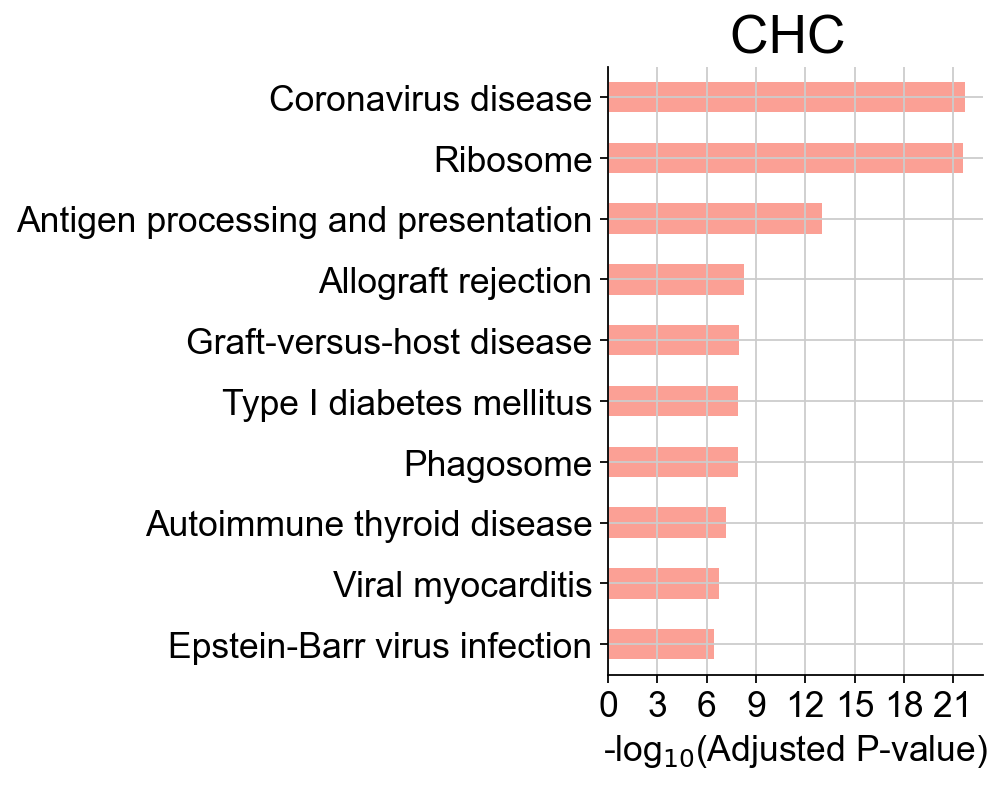

In [23]:
ax = barplot(enr_kegg.res2d,title='CHC ', figsize=(3, 5),cutoff=0.05)

In [24]:
enr_kegg.res2d.Genes.to_list()

['RPL3;RPL12;RPL36A;RPL9;RPL7;C3;RPS4X;RPL7A;RPS17;RPS15A;RPL18A;RPS18;CCL2;RPL17;RPS10;RPL39;RPS12;RPL41;RPS9;RPL21;STAT1;RPL22;ISG15;RPS3A;RPS26;RPS28;RPL26;FAU;RPL28;RPS23',
 'RPL3;RPL12;RPL36A;RPL9;RPL7;RPS4X;RPL7A;RPS17;RPS15A;RPL18A;RPS18;RPL39;RPS10;RPL17;RPS12;RPS9;RPL41;RPL21;RPL22;RPS3A;RPS26;RPS28;RPL26;FAU;RPL28;RPS23',
 'CD74;HLA-B;HLA-C;TAP1;HLA-A;HLA-F;CTSS;HLA-E;HLA-DPB1;PSME2;HLA-DRA;B2M;HLA-DRB1;HSPA1B;HLA-DPA1',
 'HLA-B;HLA-DPB1;HLA-C;HLA-DRA;HLA-A;HLA-F;HLA-DRB1;HLA-DPA1;HLA-E',
 'HLA-B;HLA-DPB1;HLA-C;HLA-DRA;HLA-A;HLA-F;HLA-DRB1;HLA-DPA1;HLA-E',
 'HLA-B;HLA-DPB1;HLA-C;HLA-DRA;HLA-A;HLA-F;HLA-DRB1;HLA-DPA1;HLA-E',
 'HLA-B;HLA-C;TAP1;CYBA;HLA-A;HLA-F;CTSS;HLA-E;C3;HLA-DPB1;HLA-DRA;ATP6V0C;HLA-DRB1;HLA-DPA1',
 'HLA-B;HLA-DPB1;HLA-C;HLA-DRA;HLA-A;HLA-F;HLA-DRB1;HLA-DPA1;HLA-E',
 'HLA-B;HLA-DPB1;HLA-C;HLA-DRA;HLA-A;HLA-F;HLA-DRB1;HLA-DPA1;HLA-E',
 'STAT1;HLA-B;HLA-C;TAP1;TNFAIP3;ISG15;HLA-A;HLA-F;HLA-E;HLA-DPB1;HLA-DRA;B2M;HLA-DRB1;HLA-DPA1',
 'COX8A;NDUFA13;NDUFB8;NDUF

In [26]:
SHsg = sc.get.rank_genes_groups_df(adata_cfa, group="HC")

In [27]:
# genes_list
enr_kegg = gp.enrichr(gene_list=list( SHsg['names']),
                 gene_sets="KEGG_2021_Human",
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
#                  description='Human',
                 outdir='test/enrichr_kegg',
#                  verbose=True,
                 no_plot=True,
#                  cutoff=1 # test dataset, use lower value from range(0,1)
                )

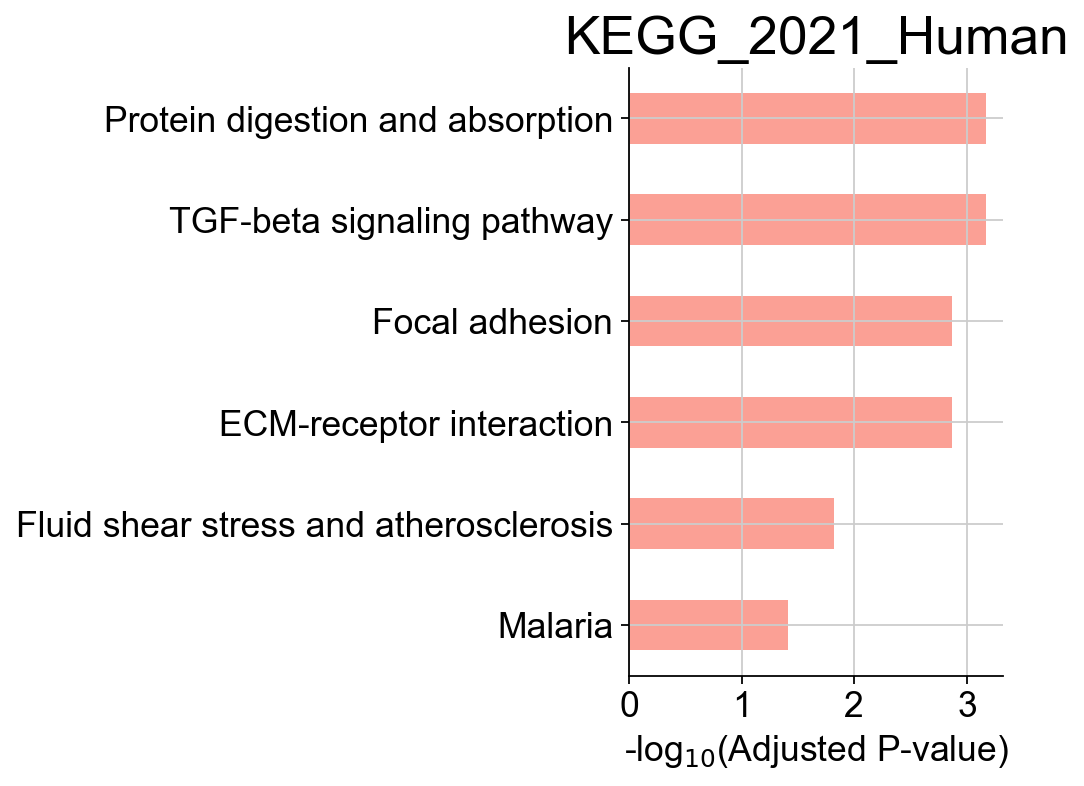

In [28]:
ax = barplot(enr_kegg.res2d,title='KEGG_2021_Human', figsize=(3, 5))

In [29]:
# diff

In [47]:
sc.tl.rank_genes_groups(adata_cfa, 'group',reference="HC",key_added="diff_gene",
                        method='wilcoxon',  use_raw =True)

ranking genes
    finished: added to `.uns['diff_gene']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


In [48]:
diffgene = sc.get.rank_genes_groups_df(adata_cfa, group="CHC",key="diff_gene")

In [49]:
diffgene[(~diffgene["logfoldchanges"].isna()) & (diffgene["pvals"] <=0.05)]

,names,scores,logfoldchanges,pvals,pvals_adj
0,HLA-B,48.742596,33.108078,0.000000e+00,0.000000e+00
1,HLA-A,45.859840,16.382242,0.000000e+00,0.000000e+00
2,HLA-C,44.712688,17.594992,0.000000e+00,0.000000e+00
3,B2M,43.225060,222.338257,0.000000e+00,0.000000e+00
4,RPL41,40.902096,17.151009,0.000000e+00,0.000000e+00
...,...,...,...,...,...
35773,TPPP3,-29.854631,-5.261904,7.643831e-196,6.360023e-193
35774,MT-ND4L,-31.165430,-5.407066,3.134490e-213,3.298406e-210
35775,SLC35F1,-31.251522,-3.792661,2.128726e-214,2.456824e-211
35776,ANGPTL1,-32.132084,-7.175627,1.571829e-226,2.249476e-223
